In [1]:
'''
Created on Wed May 3 13:03:09 2023

@author: erikycd

Task: Fine-tunning english BERT for text classification
Model: Pretrained 
Dataset: Amazon review
Process: 
    - Activate GPU for Torch
    - Loading Model and tokenizer
    - Set up special tokens
    - Read Data text info
    - Text tokenization and pytorch tensor conversion (input_ids, attention_mask)
    - DataLoader torch function for batches
    - Inference class and function
    - Set up hyper-parameters and training stage
    - Inference on new data: Conversation
    - Saving model and tokenizer
Source: nlp12_clean.py

'''

'\nCreated on Wed May 3 13:03:09 2023\n\n@author: erikycd\n\nTask: Fine-tunning english BERT for text classification\nModel: Pretrained \nDataset: Amazon review\nProcess: \n    - Activate GPU for Torch\n    - Loading Model and tokenizer\n    - Set up special tokens\n    - Read Data text info\n    - Text tokenization and pytorch tensor conversion (input_ids, attention_mask)\n    - DataLoader torch function for batches\n    - Inference class and function\n    - Set up hyper-parameters and training stage\n    - Inference on new data: Conversation\n    - Saving model and tokenizer\nSource: nlp12_clean.py\n\n'

In [1]:
#%% IMPORTING LIBRARIES

# from transformers import GPT2LMHeadModel, GPT2Tokenizer, AutoTokenizer, AutoModelForCausalLM
from transformers import BertTokenizer, BertModel, BertConfig, BertForSequenceClassification
from torch.optim import Adam
from torch.utils.data import DataLoader, RandomSampler, TensorDataset
import tqdm
import torch

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"


In [2]:
#%% SETTING UP DEVICE FOR TORCH

gpu_torch = torch.cuda.is_available()
gpu_name = torch.cuda.get_device_name(0)
print("GPU is", "available for Torch" if gpu_torch else "NOT AVAILABLE")
try:
    print('Card name: ', gpu_name)
except:
    None

device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"

GPU is available for Torch
Card name:  NVIDIA GeForce RTX 4090


In [3]:
#%% DATA EXPLORATION

path = 'C:/Users/erikycd/Downloads/Sentiment analysis dataset/'

# Read in data
df_amazon = pd.read_csv(path + 'sentiment labelled sentences/amazon_cells_labelled.txt', 
                         sep = '\t', 
                         names = ['review', 'class'])

df_amazon.head()

,review,class
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1


In [4]:
#%% DATA INFO

df_amazon.info()
print('Null values:\n', pd.isnull(df_amazon).sum())
print('Styatistic description:\n', df_amazon.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   review  1000 non-null   object
 1   class   1000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 15.8+ KB
Null values:
 review    0
class     0
dtype: int64
Styatistic description:
             class
count  1000.00000
mean      0.50000
std       0.50025
min       0.00000
25%       0.00000
50%       0.50000
75%       1.00000
max       1.00000


<Figure size 640x480 with 0 Axes>

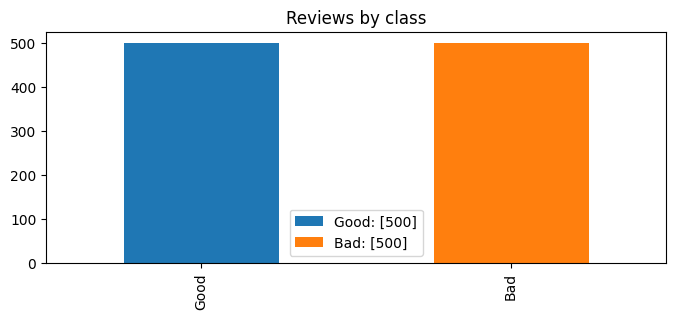

In [12]:
#%% EDA

def bar_chart_class(dataset, feature):
    
    other = dataset[dataset['class'] == 0][feature].value_counts()
    violent = dataset[dataset['class'] == 1][feature].value_counts()
    df = pd.DataFrame([other, violent])
    df.index = ['Good', 'Bad']
    plt.figure()
    df.plot(kind = 'bar', stacked = True, figsize = (8,3))
    plt.legend(['Good: {}'.format(np.array(other)), 'Bad: {}'.format(np.array(violent))])
    plt.title('Reviews by class')

bar_chart_class(df_amazon, 'class')


In [6]:
#%% ENGLISH TEXT CLEANING 

import re

def clean_text_eng(text):

    text = text.lower()
    text = re.sub(r"  ", " ", text)
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"she's", "she is", text)
    text = re.sub(r"it's", "it is", text)
    text = re.sub(r"that's", "that is", text)
    text = re.sub(r"what's", "that is", text)
    text = re.sub(r"where's", "where is", text)
    text = re.sub(r"how's", "how is", text)
    text = re.sub(r"let's", "let us", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"can't", "cannot", text)
    text = re.sub(r"n't", " not", text)
    text = re.sub(r"n'", "ng", text)
    text = re.sub(r"'bout", "about", text)
    text = re.sub(r"'til", "until", text)
    text = re.sub(r"[-()\"#/@;:<>{}`+=~|.!?,]", "", text)
    
    return text 

review_clean = []
length_review_clean = []

for k, element in enumerate(df_amazon['review']):
    review_clean.append(clean_text_eng(element))
    length_review_clean.append(len(review_clean[k].split()))


In [8]:
#%% INSERTING NEW VARIABLES

# df_data_2 = df_data.copy()
df_amazon['review_clean'] = review_clean
df_amazon['length_review_clean'] = length_review_clean

df_amazon.head(5)

,review,class,review_clean,length_review_clean
0,So there is no way for me to plug it in here i...,0,so there is no way for me to plug it in here i...,21
1,"Good case, Excellent value.",1,good case excellent value,4
2,Great for the jawbone.,1,great for the jawbone,4
3,Tied to charger for conversations lasting more...,0,tied to charger for conversations lasting more...,11
4,The mic is great.,1,the mic is great,4


Text(0.5, 1.0, 'Number of words per review')

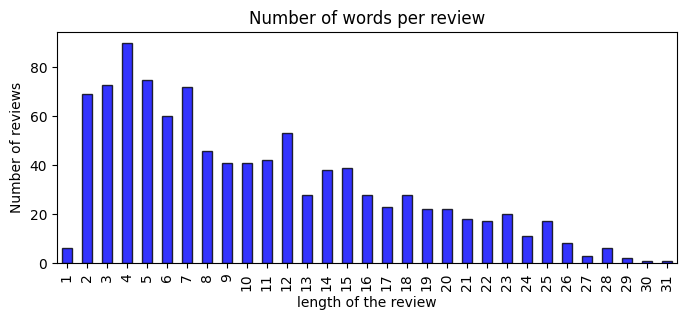

In [11]:
#%% HISTOGRAM OF WHOLE DATASET LENGTH

def bar_chart_full(dataset):
    lengths = dataset['length_review_clean'].value_counts()
    lengths = lengths.sort_index()
    plt.figure()
    lengths.plot(kind = 'bar', stacked = False, grid = False, figsize = (8,3), 
                 facecolor = 'blue', edgecolor = "black", alpha = 0.8)

bar_chart_full(df_amazon)
plt.xlabel('length of the review')
plt.ylabel('Number of reviews')
plt.title('Number of words per review')

In [13]:
#%% DOWNLOADING AND SAVING MODEL/TOKENIZER FROM HUGGINGFACE

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels = 2)


### SAVING IN LOCAL DIRECTORY
import os

output_dir = './BERT_base_uncase_pt/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

('C:/Users/erikycd/Documents/LLM/BERT_base_uncase_pt/tokenizer_config.json',
 'C:/Users/erikycd/Documents/LLM/BERT_base_uncase_pt/special_tokens_map.json',
 'C:/Users/erikycd/Documents/LLM/BERT_base_uncase_pt/vocab.txt',
 'C:/Users/erikycd/Documents/LLM/BERT_base_uncase_pt/added_tokens.json')

In [14]:
#%% LOADING MODEL FROM FILE

output_dir = './BERT_base_uncase_pt/'

model = BertForSequenceClassification.from_pretrained(output_dir,
                                                      num_labels = 2,
                                                      output_attentions = False,
                                                      output_hidden_states = False)

tokenizer = BertTokenizer.from_pretrained(output_dir)

model = model.to(device)

In [16]:
#%% PRINTING SPECIAL TOKENS 

print(tokenizer)
print('Length of tokenizer:', tokenizer.vocab_size)

print(f'The padding token is {tokenizer.pad_token} and the ID for the PAD token is {tokenizer.pad_token_id}.')
print(f'The unknown token is {tokenizer.unk_token} and the ID for the unkown token is {tokenizer.unk_token_id}.')
print(f'The seperator token is {tokenizer.sep_token} and the ID for the seperator token is {tokenizer.sep_token_id}.')
print(f'The sentence level classification token is {tokenizer.cls_token} and the ID for the classification token is {tokenizer.cls_token_id}.')
print(f'The mask token is {tokenizer.mask_token} and the ID for the mask token is {tokenizer.mask_token_id}.')

PreTrainedTokenizer(name_or_path='C:/Users/erikycd/Documents/LLM/BERT_base_uncase_pt/', vocab_size=30522, model_max_len=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})
Length of tokenizer: 30522
The padding token is [PAD] and the ID for the PAD token is 0.
The unknown token is [UNK] and the ID for the unkown token is 100.
The seperator token is [SEP] and the ID for the seperator token is 102.
The sentence level classification token is [CLS] and the ID for the classification token is 101.
The mask token is [MASK] and the ID for the mask token is 103.


In [17]:
#%% FUNCTION FOR CLEANING DATA AND CONVERTING (TEXT -> PYTORCH TENSORS)
### INPUTS: Data, Tokenizer
### OUTPUTS: Encoded sentences, attention masks

class ChatData_amazon:
    
    def __init__(self, data, tokenizer):
        
        reviews = list(data)
        self.X = reviews

        self.X_encoded = tokenizer(self.X,max_length = 40, 
                                   truncation = True, 
                                   padding = "max_length", 
                                   return_tensors = "pt")
        self.input_ids = self.X_encoded['input_ids']
        self.attention_mask = self.X_encoded['attention_mask']

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return (self.input_ids[idx], self.attention_mask[idx])


In [18]:
#%% TRAIN TEST SPLIT AND CHATDATA TENSOR

from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(df_amazon['review_clean'], 
                                                      df_amazon['class'], 
                                                      test_size = 0.2, 
                                                      random_state = 1, 
                                                      shuffle = False)

chatData_train = ChatData_amazon(X_train, tokenizer)
chatData_valid = ChatData_amazon(X_valid, tokenizer)

In [19]:
#%% CHATDATA EXAMPLE

ejemplo = 10

sentence = chatData_train.X[ejemplo]
sentence_encoded = chatData_train.input_ids[ejemplo]
sentence_attn = chatData_train.attention_mask[ejemplo]

print('Review text: ', sentence)
print('Review encoded: ', sentence_encoded)
print('Attention mask: ', sentence_attn)
print('Label: ', y_train[ejemplo])

sentence_decoded = tokenizer.decode(sentence_encoded)
print('Review decoded: ', sentence_decoded)

Review text:  and the sound quality is great
Review encoded:  tensor([ 101, 1998, 1996, 2614, 3737, 2003, 2307,  102,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0])
Attention mask:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
Label:  1
Review decoded:  [CLS] and the sound quality is great [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


In [20]:
#%% CONCATENATION OF TOKENIZATION, MASKS AND LABELS

train_set = TensorDataset(chatData_train.input_ids,
                          chatData_train.attention_mask,
                          torch.tensor(np.array(y_train))
                          )

valid_set = TensorDataset(chatData_valid.input_ids,
                          chatData_valid.attention_mask,
                          torch.tensor(np.array(y_valid))
                          )

In [21]:
#%% PYTORCH DATA LOADER

batch_sizes = 32

train_dataloader = DataLoader(train_set,  # training instances
                              sampler = RandomSampler(train_set), # Pull out batches randomly
                              batch_size = batch_sizes # train with this batch size.
                              )

valid_dataloader = DataLoader(valid_set,  # training instances
                              sampler = RandomSampler(valid_set), # Pull out batches randomly
                              batch_size = batch_sizes # train with this batch size.
                              )

In [22]:
#%% METRICS FOR VALIDATION

def b_tp(preds, labels):
    '''Returns True Positives (TP): count of correct predictions of actual class 1'''
    return sum([preds == labels and preds == 1 for preds, labels in zip(preds, labels)])

def b_fp(preds, labels):
    '''Returns False Positives (FP): count of wrong predictions of actual class 1'''
    return sum([preds != labels and preds == 1 for preds, labels in zip(preds, labels)])

def b_tn(preds, labels):
    '''Returns True Negatives (TN): count of correct predictions of actual class 0'''
    return sum([preds == labels and preds == 0 for preds, labels in zip(preds, labels)])

def b_fn(preds, labels):
    '''Returns False Negatives (FN): count of wrong predictions of actual class 0'''
    return sum([preds != labels and preds == 0 for preds, labels in zip(preds, labels)])

def b_metrics(preds, labels):
    '''
    Returns the following metrics:
      - accuracy    = (TP + TN) / N
      - precision   = TP / (TP + FP)
      - recall      = TP / (TP + FN)
      - specificity = TN / (TN + FP)
    '''
    preds = np.argmax(preds, axis = 1).flatten()
    labels = labels.flatten()
    tp = b_tp(preds, labels)
    tn = b_tn(preds, labels)
    fp = b_fp(preds, labels)
    fn = b_fn(preds, labels)
    b_accuracy = (tp + tn) / len(labels)
    b_precision = tp / (tp + fp) if (tp + fp) > 0 else 'nan'
    b_recall = tp / (tp + fn) if (tp + fn) > 0 else 'nan'
    b_specificity = tn / (tn + fp) if (tn + fp) > 0 else 'nan'
    
    return b_accuracy, b_precision, b_recall, b_specificity

In [23]:
#%% TRAINING STAGE

import time
from transformers import get_linear_schedule_with_warmup

epochs = 5
learning_rate = 1e-5
total_steps = len(train_dataloader) * epochs

optimizer = torch.optim.AdamW(model.parameters(),
                              lr = learning_rate,
                              )

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

for epoch in tqdm.tqdm(range(epochs)):
    
    print('\nTraining...')
    total_train_loss = 0
    total_correct = 0
    total_count = 0
    nb_tr_steps = 0
    
    # =================================== Training ===================================
    model.train()
    
    for step, batch in enumerate(train_dataloader):
        
        # batch = tuple(t.to(device) for t in batch)
        # b_input_ids, b_masks, b_labels = batch
        
        b_input_ids = batch[0].to(device)
        b_masks = batch[1].to(device)
        b_labels = batch[2].to(device)

        optimizer.zero_grad()

        outputs = model(b_input_ids,
                        attention_mask = b_masks,
                        token_type_ids = None,
                        labels = b_labels)

        outputs.loss.backward()
        optimizer.step()

        batch_loss = outputs.loss.item()
        total_train_loss += batch_loss
        nb_tr_steps += 1

    # torch.save(model.state_dict(), "model_state.pt")
    # print(inference('hello, how are you?'))
    
    # =================================== Validation ===================================
    model.eval()
    
    val_accuracy = []
    val_precision = []
    val_recall = []
    val_specificity = []
    
    for batch in valid_dataloader:
        
        b_input_ids = batch[0].to(device)
        b_masks = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        with torch.no_grad():
            
            eval_output = model(b_input_ids,
                                attention_mask = b_masks,
                                token_type_ids = None)
            
        logits = eval_output.logits.detach().cpu().numpy()
        labels_ids = b_labels.to('cpu').numpy()
        b_accuracy, b_precision, b_recall, b_specificity = b_metrics(logits, labels_ids)
        val_accuracy.append(b_accuracy)
        
        if b_precision != 'nan': val_precision.append(b_precision)
        # Update recall only when (tp + fn) !=0; ignore nan
        if b_recall != 'nan': val_recall.append(b_recall)
        # Update specificity only when (tn + fp) !=0; ignore nan
        if b_specificity != 'nan': val_specificity.append(b_specificity)
        
    print('\n\t - Train loss: {:.4f}'.format(batch_loss / nb_tr_steps))
    print('\t - Validation Accuracy: {:.4f}'.format(sum(val_accuracy)/len(val_accuracy)))
    print('\t - Validation Precision: {:.4f}'.format(sum(val_precision)/len(val_precision)) if len(val_precision)>0 else '\t - Validation Precision: NaN')
    print('\t - Validation Recall: {:.4f}'.format(sum(val_recall)/len(val_recall)) if len(val_recall)>0 else '\t - Validation Recall: NaN')
    print('\t - Validation Specificity: {:.4f}\n'.format(sum(val_specificity)/len(val_specificity)) if len(val_specificity)>0 else '\t - Validation Specificity: NaN')


  0%|                                                                                            | 0/5 [00:00<?, ?it/s]


Training...


 20%|████████████████▊                                                                   | 1/5 [00:03<00:15,  3.86s/it]


	 - Train loss: 0.0262
	 - Validation Accuracy: 0.8705
	 - Validation Precision: 0.9036
	 - Validation Recall: 0.8266
	 - Validation Specificity: 0.9278


Training...


 40%|█████████████████████████████████▌                                                  | 2/5 [00:05<00:06,  2.29s/it]


	 - Train loss: 0.0125
	 - Validation Accuracy: 0.9509
	 - Validation Precision: 0.9410
	 - Validation Recall: 0.9538
	 - Validation Specificity: 0.9507


Training...


 60%|██████████████████████████████████████████████████▍                                 | 3/5 [00:06<00:03,  1.79s/it]


	 - Train loss: 0.0128
	 - Validation Accuracy: 0.9420
	 - Validation Precision: 0.8204
	 - Validation Recall: 0.9447
	 - Validation Specificity: 0.9468


Training...


 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [00:07<00:01,  1.56s/it]


	 - Train loss: 0.0042
	 - Validation Accuracy: 0.9375
	 - Validation Precision: 0.9303
	 - Validation Recall: 0.9094
	 - Validation Specificity: 0.9330


Training...


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.73s/it]


	 - Train loss: 0.0052
	 - Validation Accuracy: 0.9509
	 - Validation Precision: 0.9517
	 - Validation Recall: 0.9333
	 - Validation Specificity: 0.9590



In [ ]:
#%% SAVING MODEL AND TOKENIZER

import os

output_dir = './BERT_base_uncase_pt_pretrained/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

print('Model saved!')